In [26]:
import jax
import jax.numpy as jnp
import haiku as nn
import haiku as hk
import optax as tx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

from jax.example_libraries import optimizers
from jax.example_libraries.optimizers import adamax as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)
# import os
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.50'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

In [27]:
SCALE = 1e-2
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 8)
KEY = jax.random.PRNGKey(42)
TRAIN_NEW = True

BETA = 0.8
MAX_AGE = 2.
MIN_DP = 0.2
INTEREST = 0.5

R = (1 + INTEREST)
B = BETA
BR = B * R
OBJECTIVE_FN = lambda x, t: jax.lax.select((jnp.where(t == 1, size=1)[0] == 2)[0], 
                                           jnp.array([jnp.log(x), 
                                                      x, 
                                                      0., 
                                                      1.]), 
                                           jax.lax.select((jnp.where(t == 1, size=1)[0] == 1)[0], 
                                                          jnp.array([jnp.log((1 / (1 + B)) * x) + BETA * jnp.log(R * (1 - (1 / (1 + B))) * x), 
                                                                     (1 / (1 + B)) * x, 
                                                                     R * (1 - (1 / (1 + B))) * x, 
                                                                     1.]), 
                                                          jax.lax.select((jnp.where(t == 1, size=1)[0] == 0)[0],
                                                              jnp.array([jnp.log((1 / (1 + B + B**2)) * x) +\
                                                                         BETA * jnp.log((1 / (1 + B)) * R * (1 - (1 / (1 + B + B**2))) * x) +\
                                                                         BETA**2 * jnp.log(R * (B / (1 + B)) * R * (1 - (1 / (1 + B + B**2))) * x),
                                                                         ((1) / (1 + B + B**2)) * x,
                                                                         R * (1 - ((1) / (1 + B + B**2))) * x,
                                                                         1.]),
                                                              jnp.array([0., 0., 0., 1.]))))


HIDDEN_STATE_SIZE = 8
GRID_SIZE = 100
X = jnp.linspace(1e-5, 1, GRID_SIZE)
STATE_SPACE = jnp.concatenate((
    jnp.concatenate((X.reshape(-1, 1), jnp.ones((GRID_SIZE, 1))), axis=1),
    jnp.concatenate((X.reshape(-1, 1), jnp.zeros((GRID_SIZE, 1))), axis=1)),
axis=0)

In [28]:
class Attention_Layer(nn.Module):
    def __call__(self):
        return jnp.sum(jax.nn.softmax(nn.Linear(1)(self.ys)).reshape(-1, 1) * self.ys, axis=0)
    
    def __init__(self, ys, name=None):
        super().__init__(name=name)
        self.ys = ys


class Blue_GRU(nn.Module):
    def __call__(self, ys, carry):
        d0 = carry[:(2 * self.hidden_state_size)]
        u0 = carry[(2 * self.hidden_state_size):]
        attention_layer = Attention_Layer(ys)
        
        d1, u1 = nn.GRU(2 * self.hidden_state_size)(d0, jnp.concatenate((attention_layer(), u0)))
        u1 = u1[:(self.hidden_state_size)]
        return jnp.concatenate((d1, u1)), u1
    
    def __init__(self, state_size, name=None):
        super().__init__(name=name)
        self.hidden_state_size = state_size


def custom_rnn(state_space, inputs, hidden_state_size=2):
    init_state = hk.Linear(hidden_state_size)(inputs)
    yellow_functions = [lambda x: hk.GRU(hidden_state_size)(x[0], x[1]) for i in range(state_space.shape[0])]
    blue_functions = [lambda x: Blue_GRU(hidden_state_size)(x[0], x[1]) for i in range(state_space.shape[0])]
    index = jnp.arange(len(yellow_functions))
    assert index.shape[0] == state_space.shape[0]
 
    if hk.running_init():
        # During init unconditionally take all branches to create parameters.
        example = state_space[0]
        x = jnp.array([f((example, init_state)) for f in yellow_functions]).reshape(state_space.shape[0], 2 * hidden_state_size)
        hn = x[-1, :hidden_state_size]
        ys = x[:, hidden_state_size:]
        
        x = [f((ys, jnp.concatenate((hn, jnp.zeros(2 * hidden_state_size))))) for f in blue_functions]
        dn = x[-1][0]
        us = jnp.array([y[1] for y in x])
        
        us_flat = jnp.squeeze(nn.Linear(1)(us))
        t = jnp.where(inputs == 1., size=1)[0][0]
        X = state_space[:, 0]
        o = state_space[:, 1]
        
        cu = X * jax.nn.sigmoid(us_flat / 1e3) # (n,) vector
        c = jax.lax.select((t >= MAX_AGE), X, cu)
        
        o1 = jnp.minimum(jnp.int32(X - c >= MIN_DP) + o, 1.)
        
        vu = nn.Linear(state_space.shape[0])(jnp.concatenate((us_flat, o1)))
        v = jax.lax.select((t > MAX_AGE), jnp.zeros(state_space.shape[0]), vu)
   
        predictions = jnp.concatenate((v.reshape(-1, 1), c.reshape(-1, 1)), axis=1)
    
    else:
        yellow_switch_function = lambda carry, inputs: hk.switch(inputs[0], yellow_functions, (inputs[1], carry))
        hn, ys = hk.scan(yellow_switch_function, init_state, (index, state_space))
        
        blue_switch_function = lambda carry, inputs: hk.switch(inputs[0], blue_functions, (inputs[1], carry))
        dn, us = hk.scan(blue_switch_function, jnp.concatenate((hn, jnp.zeros(2 * hidden_state_size))), (index, jnp.repeat(ys[jnp.newaxis, ...], state_space.shape[0], axis=0)))

        us_flat = jnp.squeeze(nn.Linear(1)(us))
        t = jnp.where(inputs == 1., size=1)[0][0]
        X = state_space[:, 0]
        o = state_space[:, 1]
        
        cu = X * jax.nn.sigmoid(us_flat / 1e3) # (n,) vector
        c = jax.lax.select((t >= MAX_AGE), X, cu)
        
        o1 = jnp.minimum(jnp.int32(X - c >= MIN_DP) + o, 1.)
        
        vu = nn.Linear(state_space.shape[0])(jnp.concatenate((us_flat, o1)))
        v = jax.lax.select((t > MAX_AGE), jnp.zeros(state_space.shape[0]), vu)
        
        predictions = jnp.concatenate((v.reshape(-1, 1), c.reshape(-1, 1)), axis=1)
        
    return predictions

inputs = jnp.empty(4)
rng = jax.random.PRNGKey(42)

net = hk.without_apply_rng(hk.transform(custom_rnn))
params = net.init(rng, STATE_SPACE, inputs)
preds = net.apply(params, STATE_SPACE, inputs)
preds.shape

(200, 2)

In [29]:
@jax.jit
def increment_t(t):
    i = jnp.where(t == 1, size=1)[0]
    return t.at[i].set(0).at[i+1].set(1)


@jax.tree_util.Partial(jax.jit, static_argnums=(1,))
def neural_network(params, model, model_state, inputs):
    preds = model.apply(params, model_state, inputs, hidden_state_size=HIDDEN_STATE_SIZE)
    mat = jnp.concatenate((model_state, preds), axis=1) # For a given t, we have a tensor of (X, o, v, c)
    # So we just need to add o1 and x1 columns to this tensor
    o1 = jnp.minimum(jnp.int32(mat[:, 0] - mat[:, 3] >= MIN_DP) + mat[:, 1], 1.)
    x1 = (1 + o1 * INTEREST) * (mat[:, 0] - mat[:, 3])
    preds = jnp.concatenate((mat[:, 2:], x1.reshape(-1, 1), o1.reshape(-1, 1)), axis=1)
    return preds


@jax.tree_util.Partial(jax.jit, static_argnums=(1,))
def loss(params, model, model_state, t0):
    t1 = increment_t(t0)
    preds0 = neural_network(params, model, model_state, t0)
    predicted_state = preds0[:, 2:]
    preds1 = neural_network(params, model, predicted_state, t1)
    
    v0 = preds0[:, 0]
    c0 = preds0[:, 1]
    o0 = model_state[:, 1]
    v1 = preds1[:, 0]
    c1 = preds1[:, 1]
    
    vf = lambda model_state, t: neural_network(params, model, model_state, t)[1][:, 0]
    cf = lambda model_state, t: neural_network(params, model, model_state, t)[1][:, 1]
    
    c0x = jax.vmap(lambda state: jax.grad(cf)(state, t0))(model_state)
    v0x = jax.vmap(lambda state: jax.grad(vf)(state, t0))(model_state)
    v1x = jax.vmap(lambda state: jax.grad(vf)(state, t1))(preds0[:, 2:])
    
    live_next = (jnp.where(t0 == 1, size=1)[0][0] < MAX_AGE)
    loss_euler = jax.lax.select(live_next, o0 * (c1 - BR * c0), jnp.zeros(STATE_SPACE.shape[0]))
    loss_bellman = ((jnp.log(c0) + BETA * v1) - v0)
    loss_foc = jax.lax.select(live_next, BR * v1x  * c0 - 1, jnp.zeros(STATE_SPACE.shape[0]))
    loss_envelope = (c0x - c0 * v0x)
    
    return jnp.concatenate((loss_euler.reshape(-1, 1), loss_bellman.reshape(-1, 1), loss_foc.reshape(-1, 1), loss_envelope.reshape(-1, 1)), axis=1)


@jax.tree_util.Partial(jax.jit, static_argnums=(1,))
def batch_loss(params, model, model_state, batch, W):
    losses = jax.vmap(lambda x: loss(params, model, model_state, x))(batch)
    mean_losses = jnp.squeeze(jnp.mean(losses**2, axis=0))
    return jnp.sum(W * mean_losses), tuple((mean_losses[0], mean_losses[1], mean_losses[2], mean_losses[3]))

In [30]:
@jax.tree_util.Partial(jax.jit, static_argnums=(1, 4))
def step(params, model, model_state, opt_state, optimizer, batch, W):
    (loss, (loss_euler, loss_bellman, loss_foc, loss_envelope)), grad = jax.value_and_grad(batch_loss, has_aux=True)(params, model, model_state, batch, W)
    updates, opt_state = optimizer.update(grad, opt_state, params)
    params = tx.apply_updates(params, updates)
    loss_components = tuple((loss_euler, loss_bellman, loss_foc, loss_envelope))
    return params, opt_state, loss, loss_components


def training_loop(grid, model, params, model_state, opt_state, optimizer, W=jnp.ones(4), max_iter=1000):
    j = 0
    while j < max_iter:
        params, opt_state, loss, loss_components = step(params, model, model_state, opt_state, optimizer, grid, W)
        
        if j == 0:
            start_time = time.time()
        
        if j % 1 == 0:
            print(f'Iteration: {j}\tCurrent Loss: {loss:.2f}\tAverage samples/s: {((grid.shape[0] * j) / (time.time() - start_time)):.2f}\n'
                  f'Loss Euler: {loss_components[0]}\nLoss Bellman: {loss_components[1]}\nLoss FoC: {loss_components[2]}\nLoss Envelope: {loss_components[3]}')
        j += 1
        
    return params, opt_state, model_state

In [ ]:
model = net
optimizer = tx.adam(learning_rate=1e-2)

init_model_state = STATE_SPACE
init_params = model.init(rng=KEY, state_space=init_model_state, inputs=jnp.zeros(4), hidden_state_size=HIDDEN_STATE_SIZE)
init_opt_state = optimizer.init(init_params)

if TRAIN_NEW:
    model_state = init_model_state
    params = init_params
    opt_state = init_opt_state
else:
    params, opt_state, model_state, model = pickle.load(open('rnn.pkl', 'rb'))
    
W = jnp.array([1e1, 1e-1, 1., 1.])
GRID = jnp.concatenate((jnp.eye(3), jnp.zeros(3).reshape(-1, 1)), axis=1) # 3 different ages

params, opt_state, model_state = training_loop(GRID, model, params, model_state, opt_state, optimizer, W=W, max_iter=2000)

In [9]:
_, out0 = neural_network(params, model, model_state, GRID[0])
_, out1 = neural_network(params, model, model_state, GRID[1])
_, out2 = neural_network(params, model, model_state, GRID[2])

df = pd.DataFrame(jnp.concatenate((model_state, out0, out1, out2), axis=1),
                  columns=['X', 'o0', 
                           'v00', 'c00', 'x10', 'o10',
                           'v01', 'c01', 'x11', 'o11',
                           'v02', 'c02', 'x12', 'o12'])
df_owner = df[:100].set_index('X')
df_renter = df[100:].set_index('X')

t0 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([1, 0, 0, 0]))
t1 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0, 1, 0, 0]))
t2 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0, 0, 1, 0]))
df_true = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), t0, t1, t2), axis=1),
                       columns=['X', 
                                'v00', 'c00', 'x10', 'o10',
                                'v01', 'c01', 'x11', 'o11',
                                'v02', 'c02', 'x12', 'o12']).set_index('X')

<AxesSubplot:xlabel='X'>

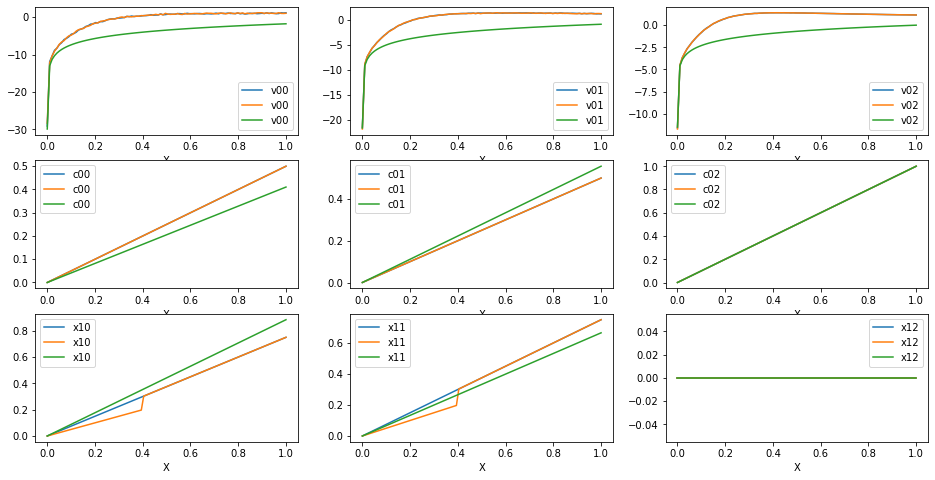

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(16, 8))

df_owner.plot(y='v00', ax=axes.flatten()[0])
df_renter.plot(y='v00', ax=axes.flatten()[0])
df_true.plot(y='v00', ax=axes.flatten()[0])
df_owner.plot(y='v01', ax=axes.flatten()[1])
df_renter.plot(y='v01', ax=axes.flatten()[1])
df_true.plot(y='v01', ax=axes.flatten()[1])
df_owner.plot(y='v02', ax=axes.flatten()[2])
df_renter.plot(y='v02', ax=axes.flatten()[2])
df_true.plot(y='v02', ax=axes.flatten()[2])

df_owner.plot(y='c00', ax=axes.flatten()[3])
df_renter.plot(y='c00', ax=axes.flatten()[3])
df_true.plot(y='c00', ax=axes.flatten()[3])
df_owner.plot(y='c01', ax=axes.flatten()[4])
df_renter.plot(y='c01', ax=axes.flatten()[4])
df_true.plot(y='c01', ax=axes.flatten()[4])
df_owner.plot(y='c02', ax=axes.flatten()[5])
df_renter.plot(y='c02', ax=axes.flatten()[5])
df_true.plot(y='c02', ax=axes.flatten()[5])

df_owner.plot(y='x10', ax=axes.flatten()[6])
df_renter.plot(y='x10', ax=axes.flatten()[6])
df_true.plot(y='x10', ax=axes.flatten()[6])
df_owner.plot(y='x11', ax=axes.flatten()[7])
df_renter.plot(y='x11', ax=axes.flatten()[7])
df_true.plot(y='x11', ax=axes.flatten()[7])
df_owner.plot(y='x12', ax=axes.flatten()[8])
df_renter.plot(y='x12', ax=axes.flatten()[8])
df_true.plot(y='x12', ax=axes.flatten()[8])

In [ ]:
pickle.dump(tuple((params, opt_state, model_state, model)), open('rnn.pkl', 'wb'))